Importando as bibliotecas necessárias

In [14]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycircular as pycircular
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()

pd.set_option('display.max_columns', None)

Unindo os dataframes

In [15]:
df_channels = pd.read_csv(r'bases\channels.csv')
df_deliveries = pd.read_csv(r'bases\deliveries.csv')
df_drivers = pd.read_csv(r'bases\drivers.csv')
df_hubs = pd.read_csv(r'bases\hubs.csv')
df_orders = pd.read_csv(r'bases\orders.csv')
df_stores = pd.read_csv(r'bases\stores.csv')
df_payments = pd.read_csv(r'bases\payments.csv')

df = pd.merge(df_orders, df_stores, on='store_id')
df = pd.merge(df, df_hubs, on='hub_id')
df = pd.merge(df, df_channels, on='channel_id')
df = pd.merge(df, df_payments, on='payment_order_id')
df = pd.merge(df, df_deliveries, on='delivery_order_id')
df = pd.merge(df, df_drivers, on='driver_id')

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,287459.0,8.229505e+07,6.980037e+06,6.841006e+07,7.649917e+07,8.319821e+07,8.792487e+07,9.313982e+07
store_id,287459.0,1.254258e+03,1.180316e+03,6.000000e+00,4.150000e+02,7.530000e+02,1.930000e+03,4.679000e+03
channel_id,287459.0,7.470592e+00,7.897336e+00,1.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,4.900000e+01
payment_order_id,287459.0,8.229505e+07,6.980037e+06,6.841006e+07,7.649917e+07,8.319821e+07,8.792487e+07,9.313982e+07
delivery_order_id,287459.0,8.229505e+07,6.980037e+06,6.841006e+07,7.649917e+07,8.319821e+07,8.792487e+07,9.313982e+07
order_amount,287459.0,9.509290e+01,1.507583e+02,0.000000e+00,3.900000e+01,6.800000e+01,1.170000e+02,2.500000e+04
order_delivery_fee,287459.0,5.465687e+00,5.942573e+00,0.000000e+00,0.000000e+00,6.000000e+00,1.100000e+01,9.900000e+02
order_delivery_cost,284781.0,7.327360e+00,3.341306e+00,0.000000e+00,5.000000e+00,7.000000e+00,8.000000e+00,1.560000e+02
order_created_hour,287459.0,1.679014e+01,6.074454e+00,0.000000e+00,1.500000e+01,1.700000e+01,2.200000e+01,2.300000e+01
order_created_minute,287459.0,2.938910e+01,1.722036e+01,0.000000e+00,1.400000e+01,2.900000e+01,4.400000e+01,5.900000e+01


# Order_metrics

Para os order_metrics de menores expressão (média dos valores menores que 8 minutos), seu valor de soma no tempo total será a ESCOLHER.

No final ver se vale mais a pena (mse_score) usar a média ou mediana

In [17]:
#Médias
avg_walking = df['order_metric_walking_time'].mean()
avg_collected = df['order_metric_collected_time'].mean()
avg_paused = df['order_metric_paused_time'].mean()

In [18]:
#Medianas
median_walking = df['order_metric_walking_time'].median()
median_collected = df['order_metric_collected_time'].median()
median_paused = df['order_metric_paused_time'].median()

# Order_metric_production_time

# Order_metric_expediton_speed_time

# Order_metric_transit_time

Para prever o tempo de trânsito, não usaremos todas as categorias.

In [19]:
colunas_transito = ['order_amount','order_delivery_fee','order_delivery_cost','order_created_hour', 'order_created_minute', 'order_created_day','order_created_month','store_latitude', 'store_longitude', 'hub_city','delivery_distance_meters', 'driver_modal','driver_type','order_metric_transit_time']

### Análise das colunas

Agora, será feita a verificação se as colunas realmente afetam a variável target

In [20]:
df_transito = df[colunas_transito]

Tempo de modo circular, utilizando a biblioteca pycircular

Serão feitas 3 colunas de tempo:
- hora, minuto
- dia, mês
- dia da semana

In [34]:
# Calculando a representação circular para as horas
df_transito['hour_angle'] = (df_transito['order_created_hour'] % 12) * 30 + (df_transito['order_created_minute'] / 60) * 30
# Normalizando os ângulos para o intervalo [0, 360)
df_transito['hour_angle'] = df_transito['hour_angle'] % 360
df_transito['radians'] = np.radians(df_transito['hour_angle'])

# Visualizando o resultado
print(df_transito[['order_created_hour', 'order_created_minute', 'hour_angle','radians']])

df_transito['datetime'] = pd.to_datetime({'year': 2021, 'month': df_transito['order_created_month'], 'day': df_transito['order_created_day']})


        order_created_hour  order_created_minute  hour_angle   radians
0                       15                    49       114.5  1.998402
1                       21                    19       279.5  4.878195
2                       20                    49       264.5  4.616396
3                       22                    35       317.5  5.541420
4                       16                    22       131.0  2.286381
...                    ...                   ...         ...       ...
287454                  22                    38       319.0  5.567600
287455                  17                     4       152.0  2.652900
287456                  16                    46       143.0  2.495821
287457                  16                    35       137.5  2.399828
287458                   0                     5         2.5  0.043633

[287459 rows x 4 columns]


0.6015220812981011


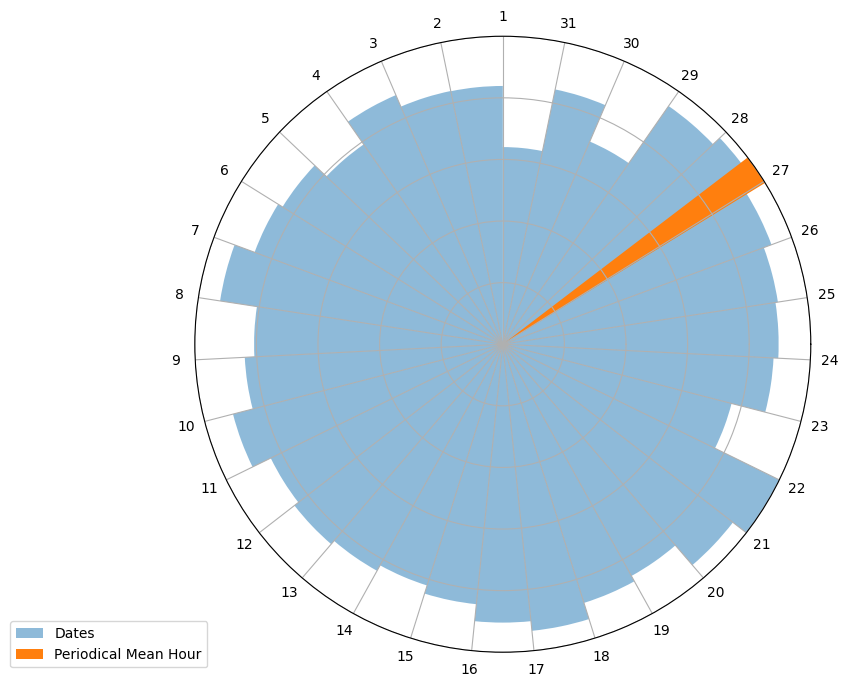

In [35]:

mean, std = pycircular.stats.periodic_mean_std(df_transito['radians'])

print(mean)
time_segment = 'daymonth'  # 'hour', 'dayweek', 'daymonth
freq_arr, times = pycircular.utils.freq_time(df_transito['datetime'] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.bar([mean], [1], width=0.1, label='Periodical Mean Hour')
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)


plt.show()

In [48]:
df_transito.head()

,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,store_latitude,store_longitude,hub_city,delivery_distance_meters,driver_modal,driver_type,order_metric_transit_time,time_day,day_complex,day_circular,time_day_sin,time_day_cos,time_complex
0,64,6,5.0,15,49,9,4,-23.595776,-46.685986,S�O PAULO,172.0,BIKER,FREELANCE,3.0,0.0,4.300000,0.0,-0.841039,-0.540974,15.816667
1,74,11,6.0,21,19,29,1,-23.561052,-46.558975,S�O PAULO,2265.0,MOTOBOY,FREELANCE,17.0,0.0,1.966667,0.0,-0.646124,0.763232,21.316667
2,82,9,8.0,20,49,18,2,-22.996847,-43.361200,RIO DE JANEIRO,2175.0,MOTOBOY,FREELANCE,42.0,0.0,2.600000,0.0,-0.740218,0.672367,20.816667
3,85,9,8.0,22,35,9,1,-22.996847,-43.361200,RIO DE JANEIRO,2175.0,MOTOBOY,LOGISTIC OPERATOR,22.0,0.0,1.300000,0.0,-0.362438,0.932008,22.583333
4,107,11,6.0,16,22,3,1,-23.017473,-43.479940,RIO DE JANEIRO,273.0,BIKER,FREELANCE,15.0,0.0,1.100000,0.0,-0.909961,-0.414693,16.366667


Análise estatísica:

- Variáveis numéricas: T-test
- Variáveis categóricas: Chi square

Data Prep

modelo

# Modelo

Função preparação

In [5]:
grupo_pagamento = {
'DEBIT': 'CARD',
'CREDIT': 'CARD',
'DEBIT_STORE': 'CARD',
'CREDIT_STORE': 'CARD',
'INSTALLMENT_CREDIT_STORE': 'CARD',
'MEAL_BENEFIT': 'OTHER',
'STORE_DIRECT_PAYMENT': 'OTHER',
'PAYMENT_LINK': 'OTHER',
'MONEY': 'OTHER',
'BANK_TRANSFER_DC': 'OTHER',
'VOUCHER_DC': 'VOUCHER',
'VOUCHER_OL': 'VOUCHER',
'VOUCHER_STORE': 'VOUCHER'
}

def preparacao(df):
    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
        'order_moment_collected', 'order_moment_in_expedition',
        'order_moment_delivering', 'order_moment_delivered'])

    df = df[~df['order_status'].isin(['CANCELED'])]
    df = df[~df['delivery_status'].isin(['DELIVERING'])]
    df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]
    df['payment_method'] = df['payment_method'].replace(grupo_pagamento)
    
    df = df.drop(columns=['order_status','payment_status','delivery_status','payment_fee'])

    #duplicadas
    df = df.drop_duplicates()

    df = df.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_moment_finished','order_metric_cycle_time'])

    df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
    df['store_plan_price'] = df['store_plan_price'].fillna(0.0)

    df['order_moment_created'] = pd.to_datetime(df['order_moment_created'])
    df['order_moment_finished'] = pd.to_datetime(df['order_moment_finished'])

    # Calcular a diferença entre as duas colunas em minutos
    df['order_metric'] = (df['order_moment_finished'] - df['order_moment_created']).dt.total_seconds() / 60

    # Exibir o DataFrame resultante
    print(df['order_metric'])

    df = df.loc[df['order_metric'] >= 0]


    #duplicados e inconsistentes
    df = df.drop_duplicates()
    df = df.loc[df['order_metric_transit_time'] >= 0]
    df = df.loc[df['order_metric_walking_time'] >= 0]
    df = df.loc[df['order_metric_paused_time'] >= 0]
    df = df.loc[df['order_metric_collected_time'] >= 0]

    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
       'order_moment_collected', 'order_moment_in_expedition',
       'order_moment_delivering', 'order_moment_delivered'])



analise de cada coluna

In [15]:
df.head()

,order_id,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,order_moment_created,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,store_segment,store_plan_price,store_latitude,store_longitude,hub_city,hub_latitude,hub_longitude,channel_type,payment_amount,payment_fee,payment_method,delivery_distance_meters,driver_modal,driver_type
0,89066010,64,6,5.0,15,49,9,4,4/9/2021 3:49:59 PM,4/9/2021 4:27:23 PM,4.0,4.0,20.0,8.0,12.0,3.0,37.0,FOOD,49.0,-23.595776,-46.685986,S�O PAULO,-23.595001,-46.685986,MARKETPLACE,71.22,1.07,ONLINE,172.0,BIKER,FREELANCE
1,74452603,74,11,6.0,21,19,29,1,1/29/2021 9:19:06 PM,1/29/2021 9:56:32 PM,0.0,0.0,15.0,3.0,4.0,17.0,37.0,FOOD,NaN,-23.561052,-46.558975,S�O PAULO,-23.561052,-46.558975,MARKETPLACE,86.80,2.34,ONLINE,2265.0,MOTOBOY,FREELANCE
2,78635930,82,9,8.0,20,49,18,2,2/18/2021 8:49:48 PM,2/18/2021 9:48:07 PM,1.0,6.0,4.0,4.0,11.0,42.0,58.0,FOOD,0.0,-22.996847,-43.361200,RIO DE JANEIRO,-22.996847,-43.359634,MARKETPLACE,92.80,1.39,ONLINE,2175.0,MOTOBOY,FREELANCE
3,70338727,85,9,8.0,22,35,9,1,1/9/2021 10:35:40 PM,1/9/2021 11:13:46 PM,2.0,1.0,8.0,6.0,7.0,22.0,38.0,FOOD,49.0,-22.996847,-43.361200,RIO DE JANEIRO,-22.996847,-43.359634,MARKETPLACE,94.90,1.42,ONLINE,2175.0,MOTOBOY,LOGISTIC OPERATOR
4,68874888,107,11,6.0,16,22,3,1,1/3/2021 4:22:42 PM,1/3/2021 5:07:33 PM,5.0,3.0,20.0,5.0,8.0,15.0,44.0,FOOD,0.0,-23.017473,-43.479940,RIO DE JANEIRO,-23.017473,-43.479940,MARKETPLACE,119.25,3.22,ONLINE,273.0,BIKER,FREELANCE


outliers

In [252]:
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame

outlier_df = conta_outliers(df)
print(outlier_df)

                               Coluna  Outliers  Porcentagem       lim_inf  \
0                            order_id         0     0.000000  5.882139e+07   
1                        order_amount     11639     5.033495 -7.450000e+01   
2                  order_delivery_fee        64     0.027678 -1.650000e+01   
3                 order_delivery_cost      9065     3.920322  5.000000e-01   
4                  order_created_hour     20224     8.746232  4.500000e+00   
5                order_created_minute         0     0.000000 -3.100000e+01   
6                   order_created_day         0     0.000000 -1.350000e+01   
7                 order_created_month         0     0.000000 -1.000000e+00   
8         order_metric_collected_time     14631     6.327439 -3.000000e+00   
9            order_metric_paused_time     20141     8.710337 -5.000000e+00   
10       order_metric_production_time      9071     3.922917 -9.000000e+00   
11          order_metric_walking_time     10851     4.692710 -2.

heatmap

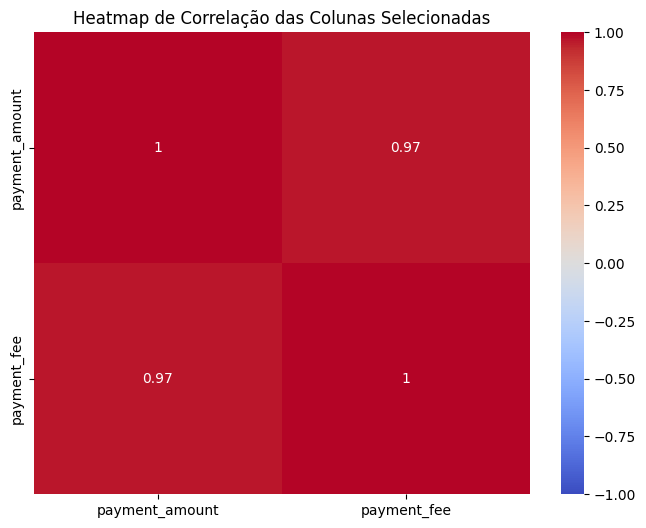

In [16]:
#Análise colunas midiáticas

colunas = ['payment_amount','payment_fee']
df_subset = df[colunas]

# Criar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação das Colunas Selecionadas')
plt.show()

Muito correlacionado, utilizar apenas um no modelo ESCOLHER QUAL

In [256]:
df = df.drop(columns='payment_fee')

In [257]:
# Selecionando apenas as colunas numéricas do DataFrame
numeric_columns = df.select_dtypes(include=['int', 'float'])

# Exibindo as colunas numéricas
print(numeric_columns)


        order_id  order_amount  order_delivery_fee  order_delivery_cost  \
0       89066010            64                   6                  5.0   
1       74452603            74                  11                  6.0   
2       78635930            82                   9                  8.0   
3       70338727            85                   9                  8.0   
4       68874888           107                  11                  6.0   
...          ...           ...                 ...                  ...   
287453  85008042            75                   0                  9.0   
287454  86909485            26                   0                  5.0   
287456  88807164            52                   6                  0.0   
287457  88616043            23                   0                  0.0   
287458  77819085            74                   1                  8.0   

        order_created_hour  order_created_minute  order_created_day  \
0                       15  

In [259]:
def cat_var(tab, x):
  if x == 0:
    cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
  if x == 1:
    cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
  return cat

In [260]:
def preparacao(tab):
  dados = cat_var(tab, 1)
  dados = tab[dados[:-1]]
  
  order_metric_cycle_time = cat_var(tab, 1)
  order_metric_cycle_time = tab[order_metric_cycle_time[-1]]
  return dados, order_metric_cycle_time 

In [261]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [262]:
# Seleciona apenas as colunas que não são do tipo 'object'
numeric_columns = df.select_dtypes(exclude=['object'])

# Cria um novo DataFrame apenas com as colunas numéricas
new_df = df[numeric_columns.columns]

In [270]:
# Suponha que df é o seu DataFrame com as colunas necessárias
def treino(df):
    # Passo 1: Divida o DataFrame em X e y
    X,Y = preparacao(df)

    print(df)

    # Passo 2: Divida os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Passo 3: Importe o modelo de regressão linear
    model = LinearRegression()

    # Passo 4: Ajuste o modelo aos dados de treinamento
    model.fit(X_train, y_train)

    # Passo 5: Faça previsões usando os dados de teste
    y_pred = model.predict(X_test)

    # Passo 6: Calcule o MSE
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Exemplo de uso:
    rmse_value = rmse(y_test, y_pred)
    print("RMSE:", rmse_value)